In [1]:
import pandas as pd
df = pd.read_stata(rf"Data\Data_Output\ordered_text.dta")


In [1]:
import xarray as xr
ds = xr.open_dataset(r"D:\Downloads\bsose_i105_2008to2012_monthly_Mu.nc")

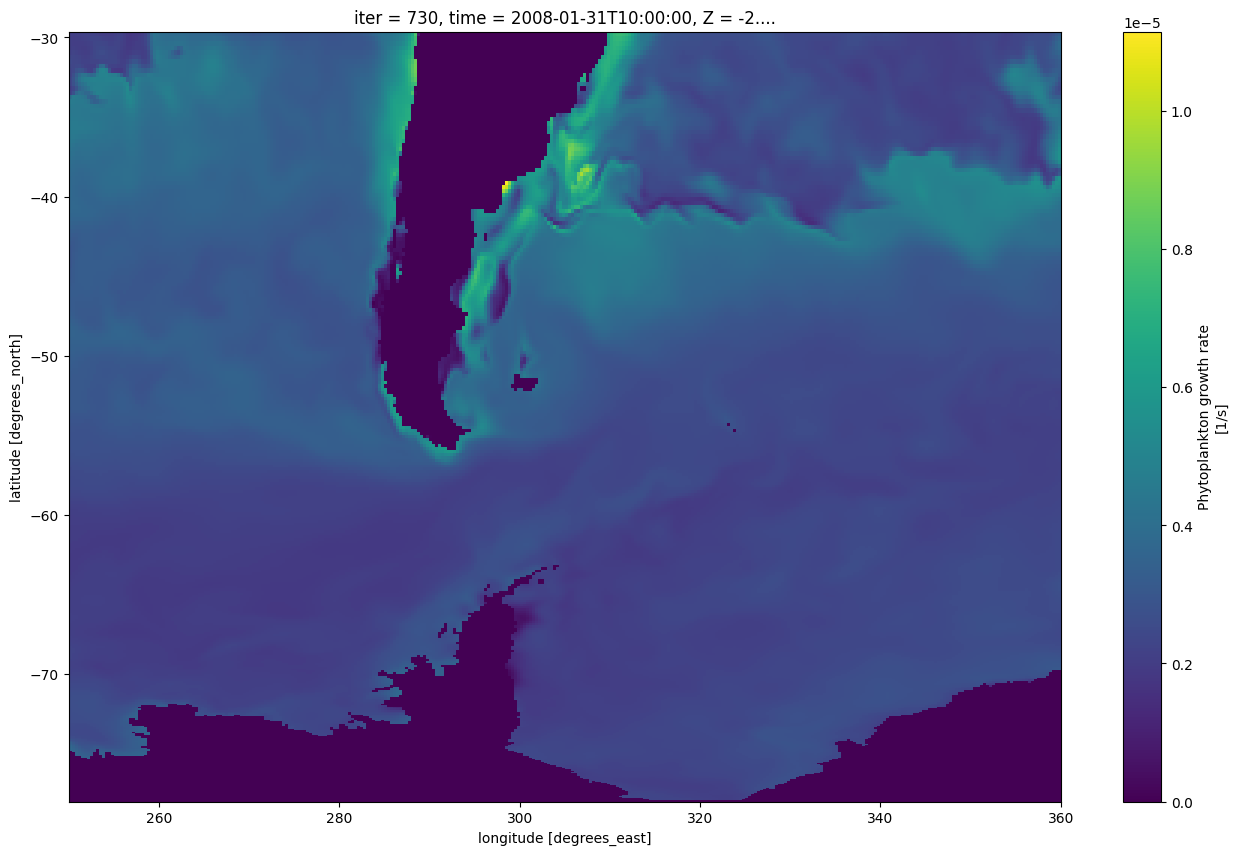

In [29]:
import matplotlib.pyplot as plt
ds.sel(Z=-2.1, time=ds.time[0], XC=slice(250, 360))['BLGMU'].plot(figsize=(16, 10))
# plt.axis('off')

In [10]:
try:
    from sfi import Macro

    root = Macro.getGlobal("root")
    data_raw = Macro.getGlobal("data_raw")
    data_processed = Macro.getGlobal("data_processed")
    data_output = Macro.getGlobal("data_output")
    excels = Macro.getGlobal("excels")
    date = Macro.getGlobal("date")  # Date when the full process is run
    extra = Macro.getGlobal(
        "extra"
    )  # Placeholder for testing, just add "_test" or something like that to avoid overwrite db

except:
    root = r"D:\Laboral\World Bank\Data-Portal-Brief-Generator"
    # portal = r"C:\Users\llohi\OneDrive - Universidad Torcuato Di Tella\WB\Data-Portal-Brief-Generator"
    data_raw = rf"{root}\Data\Data_Raw"
    data_processed = rf"{root}\Data\Data_Processed"
    data_output = rf"{root}\Data\Data_Output"
    extra = ""

sources = rf"{root}\Sources"
briefs = rf"{root}\Briefs"
excels = rf"{root}\Datasheets"

import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pdf2image import convert_from_path


def list_files_in_directory(folder_path):
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list


def resize_image(image, new_width):
    old_width = image.size[0]
    old_height = image.size[1]
    new_height = int(old_height * (new_width / old_width))
    return image.resize((new_width, new_height)), new_height


def add_header_and_footer(background, header, footer):
    # Resize the header and footer images to match the background size
    new_width = background.size[0] + 2
    header, new_height = resize_image(header, new_width)
    footer, new_height = resize_image(footer, new_width)

    # Create a new image with transparency
    merged_image = Image.new("RGB", background.size)

    # Paste the background image onto the new image
    merged_image.paste(background, (0, 0))

    # Paste the footer image onto the new image, using the alpha channel of the footer
    merged_image.paste(footer, (-1, background.size[1] - new_height + 2), mask=footer)
    merged_image.paste(header, (-1, -1), mask=header)

    return merged_image


df = pd.read_stata(rf"{data_output}\ordered_text.dta")
df = df.sort_values(by=["wbregion", "wbcode"])
# df = df[df.wbcode.isin(["AUT"])]
df = df[df.wbregion == "East Asia & Pacific"]

headers = list_files_in_directory(rf"{sources}\\Header Images\\Headers pngs")
images = {k: [] for k in df.wbregion.unique()}
for country_data in tqdm(df[["wbcode", "wbcountryname", "wbregion"]].itertuples()):
    try:
        wbcode = country_data[1]
        wbcountryname = country_data[2]
        wbregion = country_data[3]

        # print(wbcode)
        pdf = convert_from_path(
            rf"{briefs}\{wbcountryname}\{wbcountryname}{extra}.pdf",
            size=(1700 * 2.5, 2200 * 2.5),
        )  # This returns a list even for a 1 page pdf

        ## P1
        header_path = [header for header in headers if f"1-HCCB-{wbcode}" in header][0]
        header = Image.open(header_path)
        footer = Image.open(rf"{sources}\Footer Images\p1 footer.png")

        page_1 = add_header_and_footer(pdf[0], header, footer)

        ## P2
        header_path = [header for header in headers if f"2-HCCB-{wbcode}" in header][0]
        header = Image.open(header_path)
        footer = Image.open(rf"{sources}\Footer Images\p2 footer.png")

        page_2 = add_header_and_footer(pdf[1], header, footer)

        # Save them
        # page_1.save(
        #     rf"{briefs}\For print\{wbregion}\{wbcountryname}{extra}.pdf",
        #     "PDF",
        #     mode="RGBA",
        #     resolution=100.0,
        #     save_all=True,
        #     append_images=[page_2],
        # )
        images[wbregion] += [page_1, page_2]

    except Exception as exception:
        print(f"Error with {wbcode}: {exception}")

31it [01:27,  2.82s/it]


In [18]:
for region, imgs in images.items():
    os.makedirs(rf"{briefs}\For print\{region}_", exist_ok=True)

    imgs[0].save(
        rf"{briefs}\For print\{region}_\{region}_{extra}.pdf",
        "PDF",
        mode="RGBA",
        resolution=100.0,
        save_all=True,
        append_images=imgs[1:],
    )
    imgs = []